# Network analysis of supplier On-Tim Delivery (OTD)
The following code generates the figures found in the essay *Network analysis of supplier On-Time Delivery*. The essay can be found [here](https://static1.squarespace.com/static/5b722db6f2e6b1ad5053391b/t/67a635232700da46098b6d60/1738945828468/Network+analysis+of+supplier+on+time+delivery.pdf).

Several figures in the following code are generated with the Python package `process_improvement.py`. This package can be found [here](https://pypi.org/project/process-improvement/). Package can be installed using `pip install process-improvement`.

In [4]:
# Import libraries
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Import modules from process_improvement
from process_improvement import xmr_charts as xmr
from process_improvement import network_analysis as na

%matplotlib inline

In [6]:
# Dataset URL
dataset_url = r'https://raw.githubusercontent.com/jimlehner/broken-quality-initiative/refs/heads/main/data/network_analysis_of_supplier_on_time_delivery-supplier_on_time_delivery_data.csv'

# Get data
def get_data() -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
df = get_data()

# Specify dtypes
df[['Supplier','Month']] = df[['Supplier','Month']].astype('string')

df.dtypes

Index        int64
Supplier    string
Month       string
OTD          int64
dtype: object

## Fig 1: Network analysis of key supplier OTD

In [7]:
# Get unique process states
supplier_list = df['Supplier'].unique().tolist()
# Create list of dfs for use in network_analysis
list_of_dfs = [df[df['Supplier'] == supplier].reset_index(drop=True) for supplier in supplier_list]

In [76]:
# This version of network analysis limits the Upper Process Limit to 100
# This version of network analysis is avalible in process_improvement.py 1.1.0
def network_analysis(df_list, condition, label_list, title='Network Analysis', rows=1, 
                     cols=2, linestyle='-', xticks=False, hide_last='Off', color=None,
                     round_value=3, figsize=(15,10), dpi=300):
    
    """
    Perform network analysis on a list of DataFrames, plotting control charts and returning statistical summaries.

    Parameters:
    -----------
    df_list : list of pandas.DataFrame
        List of DataFrames containing the data to be analyzed.
    condition : str
        Column name in the DataFrames to be used for analysis.
    label_list : list of str
        List of labels corresponding to each DataFrame for plot titles.
    title : str, optional (default='Network Analysis')
        Title for the overall figure.
    rows : int, optional (default=1)
        Number of rows in the subplot grid.
    cols : int, optional (default=2)
        Number of columns in the subplot grid.
    linestyle : str, optional (default='-')
        Line style for the data plots.
    xticks : bool, optional (default=False)
        Whether to display x-axis ticks.
    hide_last : str, optional (default='Off')
        Whether to hide the last subplot. Options are 'On' or 'Off'.
    color : list of str, optional
        List of colors for the data plots. If not provided, defaults to ['tab:blue'].
    figsize : tuple, optional (default=(15, 10))
        Size of the overall figure.
    dpi : int, optional (default=300)
        Dots per inch for the figure resolution.

    Returns:
    --------
    results_df : pandas.DataFrame
        DataFrame containing the calculated statistics and predictability characterization for each DataFrame.

    Raises:
    -------
    ValueError
        If `condition` is not a column in any of the DataFrames in `df_list`.
        If the length of `label_list` does not match the length of `df_list`.

    Notes:
    ------
    - The function calculates the mean, average moving range (AmR), upper control limit (UPL),
      lower control limit (LPL), and upper range limit (URL) for each DataFrame.
    - It generates control charts for the data and masks values exceeding the control limits.
    - It determines if the data is 'Predictable' or 'Unpredictable' based on control limits.

    Example:
    --------
    >>> data1 = pd.Series([80, 90, 85, 95, 100])
    >>> data2 = pd.Series([120, 125, 130, 135, 140])
    >>> df_list = [pd.DataFrame({'value': data1}), pd.DataFrame({'value': data2})]
    >>> condition = 'value'
    >>> label_list = ['Data 1', 'Data 2']
    >>> results = network_analysis(df_list, condition, label_list)
    >>> print(results)
    """
    
    if color is None:
        color = ['tab:blue']
    
    # Ensure the color list is long enough for the number of plots
    if len(color) < len(df_list):
        color = (color * (len(df_list) // len(color) + 1))[:len(df_list)]
    
    # Validate inputs
    if not all(condition in df.columns for df in df_list):
        raise ValueError("Condition must be a column in all dataframes.")
    if len(label_list) != len(df_list):
        raise ValueError("Label list must have the same length as the dataframe list.")
    
    # Constants for control limits
    C1 = 2.660
    C2 = 3.268
    
    # Calculate statistics
    stats = [
        (
            df[condition].mean(),
            abs(df[condition].diff()).mean(),
            min(df[condition].mean() + C1 * abs(df[condition].diff()).mean(),100),
            max(df[condition].mean() - C1 * abs(df[condition].diff()).mean(),0),
            C2 * abs(df[condition].diff()).mean()
        )
        for df in df_list
    ]
    
    # Create results dataframe
    parameters_df = pd.DataFrame(stats, columns=['Mean', 'AmR', 'UPL', 'LPL', 'URL'])
    parameters_df['Labels'] = label_list
    parameters_df['PLR'] = parameters_df['UPL'] - parameters_df['LPL']
    parameters_df['data'] = [df[condition] for df in df_list]
    parameters_df['mR'] = [df[condition].diff() for df in df_list]
    
    # Determine characterization
    parameters_df['Characterization'] = parameters_df.apply(
        lambda row: 'Predictable' if all(row['LPL'] <= x <= row['UPL'] for x in row['data']) else 'Unpredictable',
        axis=1
    )
    
    # Plotting
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, sharey=True, dpi=dpi)
    plt.subplots_adjust(wspace=0)
    plt.suptitle(title, fontsize=12, y=1.05)

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for idx, (data, UPL, LPL, label, ax) in enumerate(zip(
            parameters_df['data'], parameters_df['UPL'], parameters_df['LPL'], parameters_df['Labels'], axes)):
        
        # Plot data
        ax.plot(data, marker='o', ls=linestyle, color=color[idx % len(color)])

        # Masking and plotting limits
        ax.plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
        ax.plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
        
        # Highlight points where the data is zero in red
        zero_indices = (data == 0)
        ax.plot(np.where(zero_indices)[0], data[zero_indices], marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    
        # Plotting lines for mean, UPL, and LPL
        mean = np.mean(data)
        ax.axhline(mean, ls='--', color='black')
        ax.axhline(UPL, ls='--', color='red')
        ax.axhline(LPL, ls='--', color='red')
        
        # Styling axes
        ax.grid(False)
        ax.set_title(label, fontsize=12)
        for spine in ['top', 'right', 'bottom']:
            ax.spines[spine].set_visible(False)
        ax.spines['left'].set_alpha(0.5)
        ax.tick_params(axis='both', which='both', length=0)
        
        if not xticks:
            ax.set_xticks([])

    # Hide the last subplot by removing its axis
    if hide_last.lower() == 'on':
        axes[-1].axis('off')
    
    # Show figure 
    plt.show()
    
    # Reorder and return the results dataframe
    new_order = ['Labels', 'Mean', 'UPL', 'LPL', 'PLR', 'AmR', 'URL', 'Characterization']
    results_df = parameters_df[new_order]
    
    return results_df

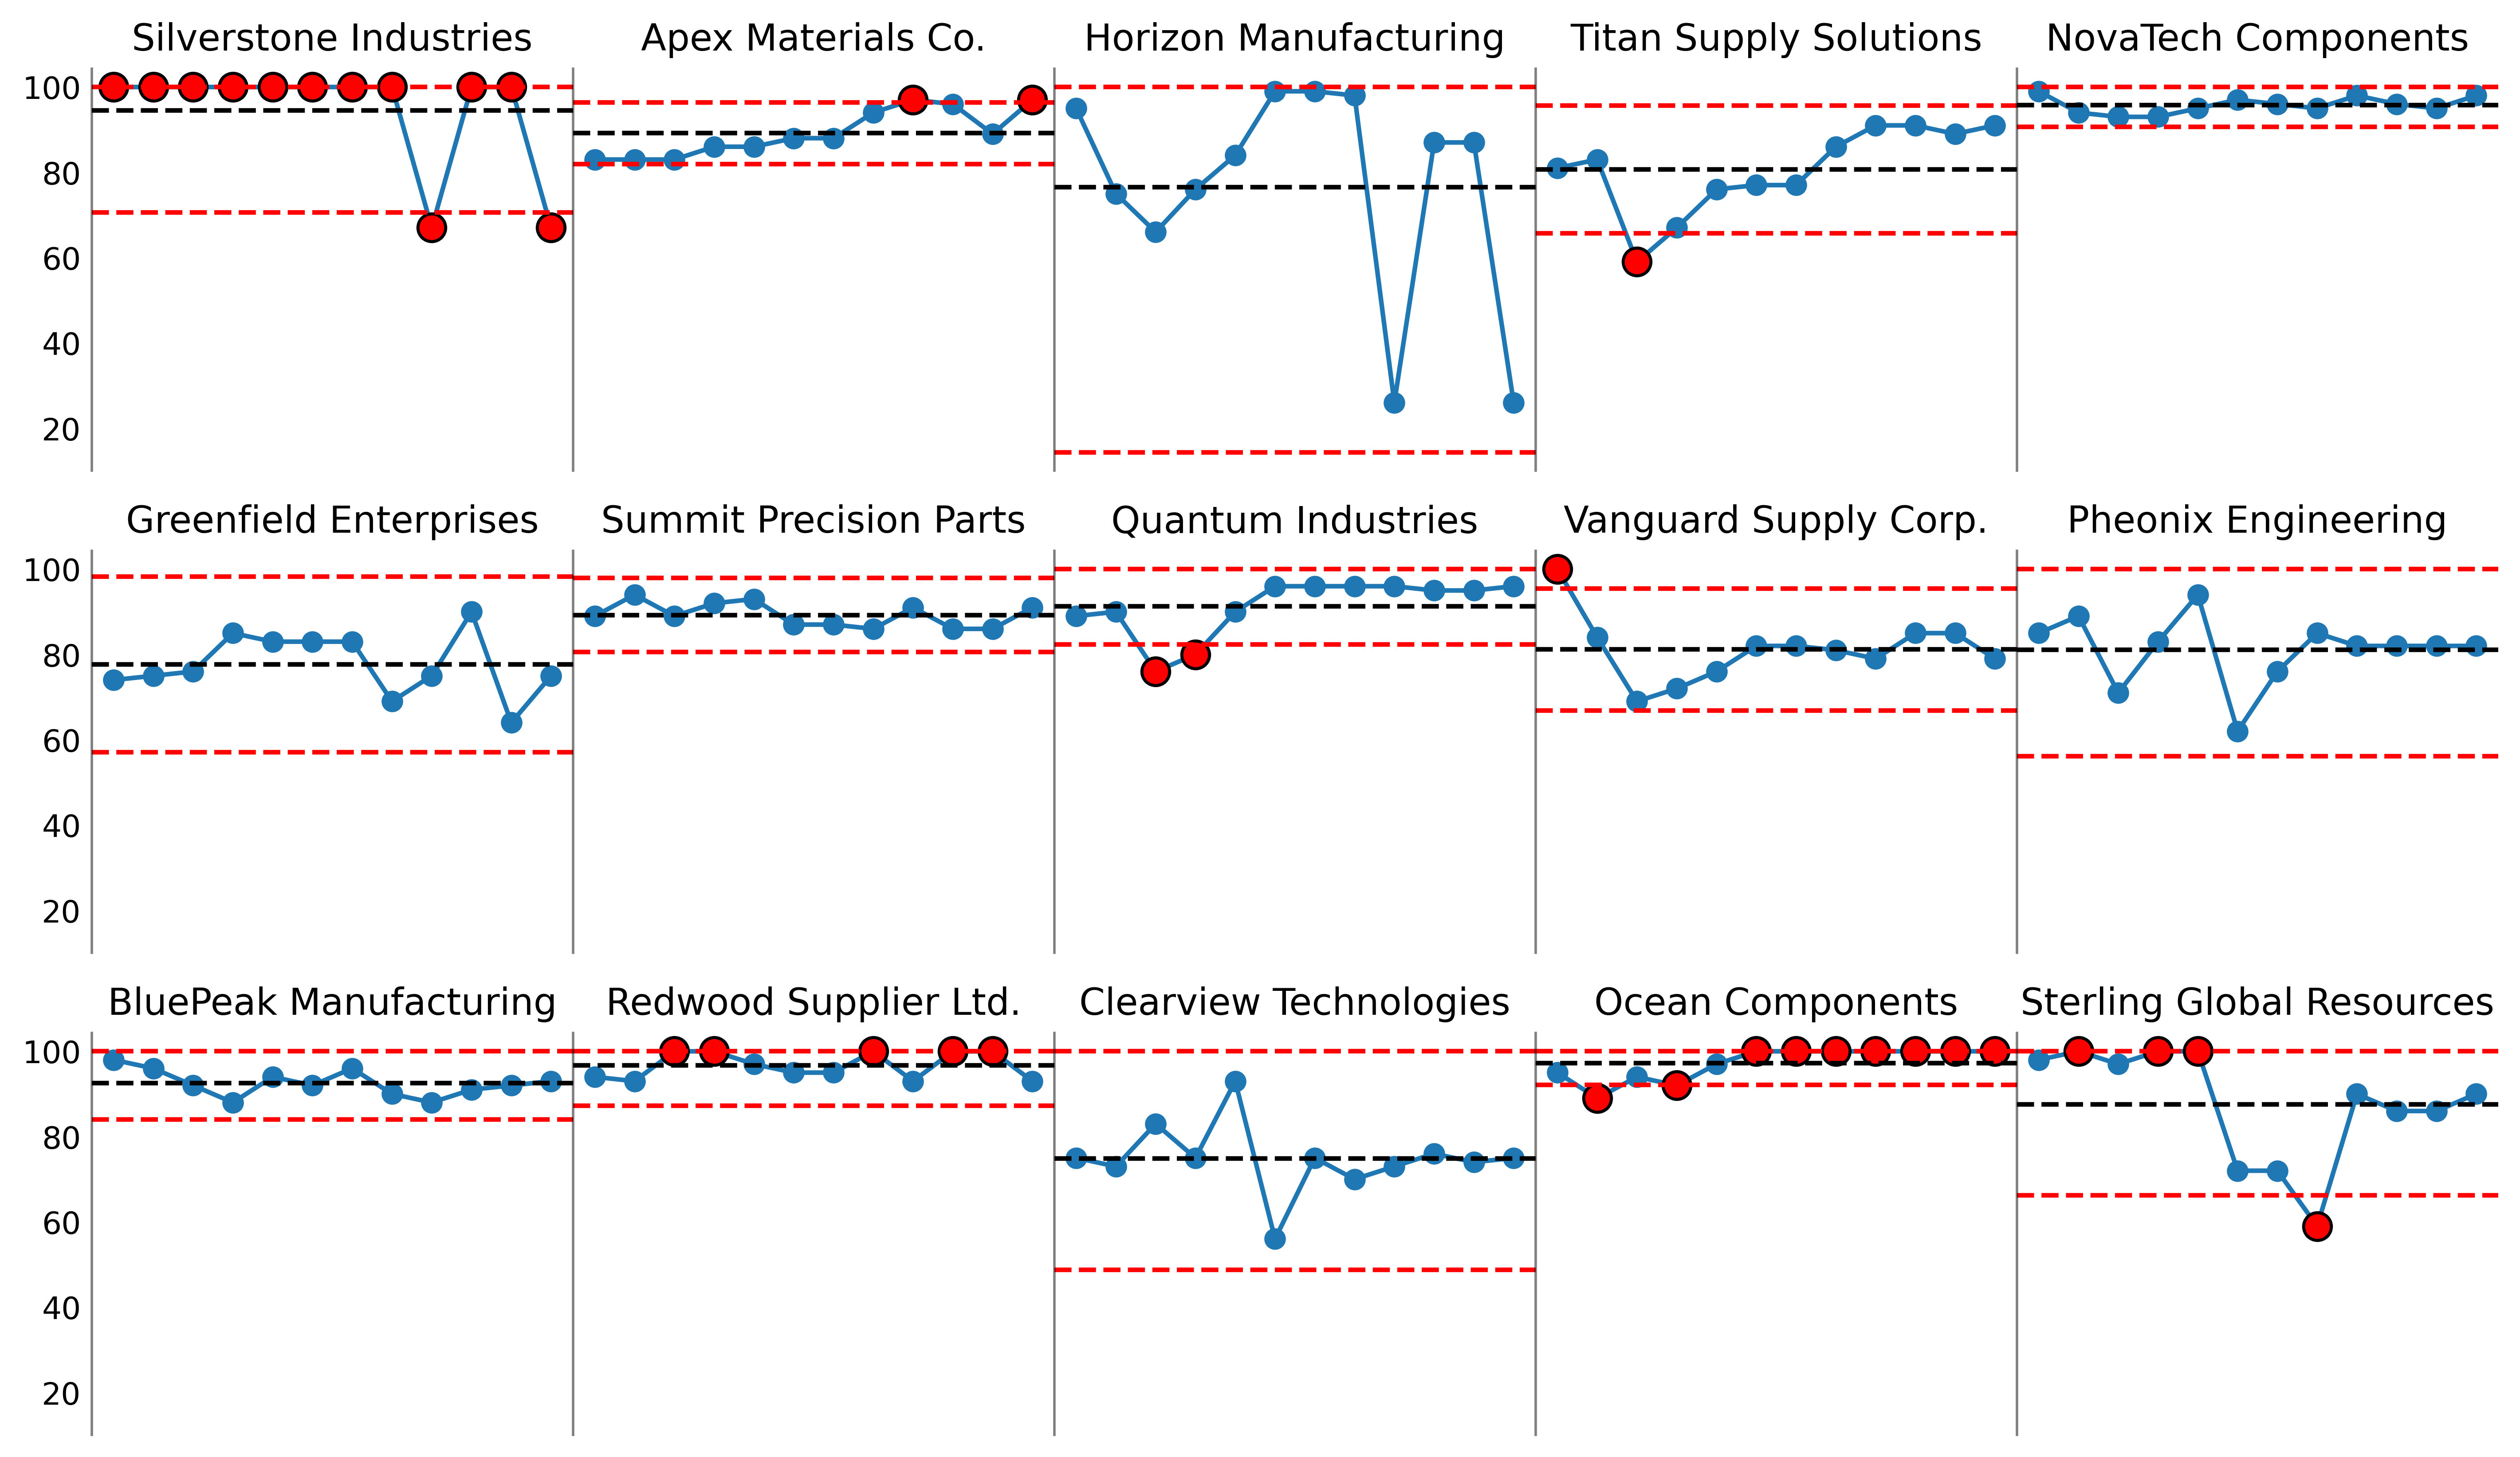

In [54]:
# Perform the network analysis
na_results = network_analysis(list_of_dfs, 'OTD', supplier_list,
                   figsize=(14,8), rows=3, cols=5,
                   title='', dpi=500)

In [55]:
# Show results dataframe
round(na_results)

,Labels,Mean,UPL,LPL,PLR,AmR,URL,Characterization
0,Silverstone Industries,94.0,100.0,71.0,29.0,9.0,29.0,Unpredictable
1,Apex Materials Co.,89.0,96.0,82.0,15.0,3.0,9.0,Unpredictable
2,Horizon Manufacturing,76.0,100.0,14.0,86.0,23.0,76.0,Predictable
3,Titan Supply Solutions,81.0,96.0,66.0,30.0,6.0,18.0,Unpredictable
4,NovaTech Components,96.0,100.0,91.0,9.0,2.0,6.0,Predictable
5,Greenfield Enterprises,78.0,98.0,57.0,41.0,8.0,25.0,Predictable
6,Summit Precision Parts,89.0,98.0,81.0,17.0,3.0,11.0,Predictable
7,Quantum Industries,91.0,100.0,82.0,18.0,3.0,11.0,Unpredictable
8,Vanguard Supply Corp.,81.0,95.0,67.0,29.0,5.0,18.0,Unpredictable
9,Pheonix Engineering,81.0,100.0,56.0,44.0,9.0,31.0,Predictable


## Fig 2: Supplier OTD means bar chart

In [56]:
# Sort network analysis results by characterization and mean
na_means_sorted = round(na_results.sort_values(by=['Characterization','Mean'], ascending=[False, True]),1)
na_means_sorted

,Labels,Mean,UPL,LPL,PLR,AmR,URL,Characterization
3,Titan Supply Solutions,80.7,95.7,65.7,30.0,5.6,18.4,Unpredictable
8,Vanguard Supply Corp.,81.2,95.4,66.9,28.5,5.4,17.5,Unpredictable
14,Sterling Global Resources,87.5,100.0,66.2,33.8,8.0,26.1,Unpredictable
1,Apex Materials Co.,89.2,96.4,81.9,14.5,2.7,8.9,Unpredictable
7,Quantum Industries,91.2,100.0,82.3,17.7,3.4,11.0,Unpredictable
0,Silverstone Industries,94.5,100.0,70.6,29.4,9.0,29.4,Unpredictable
13,Ocean Components,97.2,100.0,92.2,7.8,1.9,6.2,Unpredictable
12,Clearview Technologies,74.8,100.0,48.7,51.3,9.8,32.1,Predictable
2,Horizon Manufacturing,76.5,100.0,14.4,85.6,23.4,76.4,Predictable
5,Greenfield Enterprises,77.7,98.2,57.1,41.1,7.7,25.3,Predictable


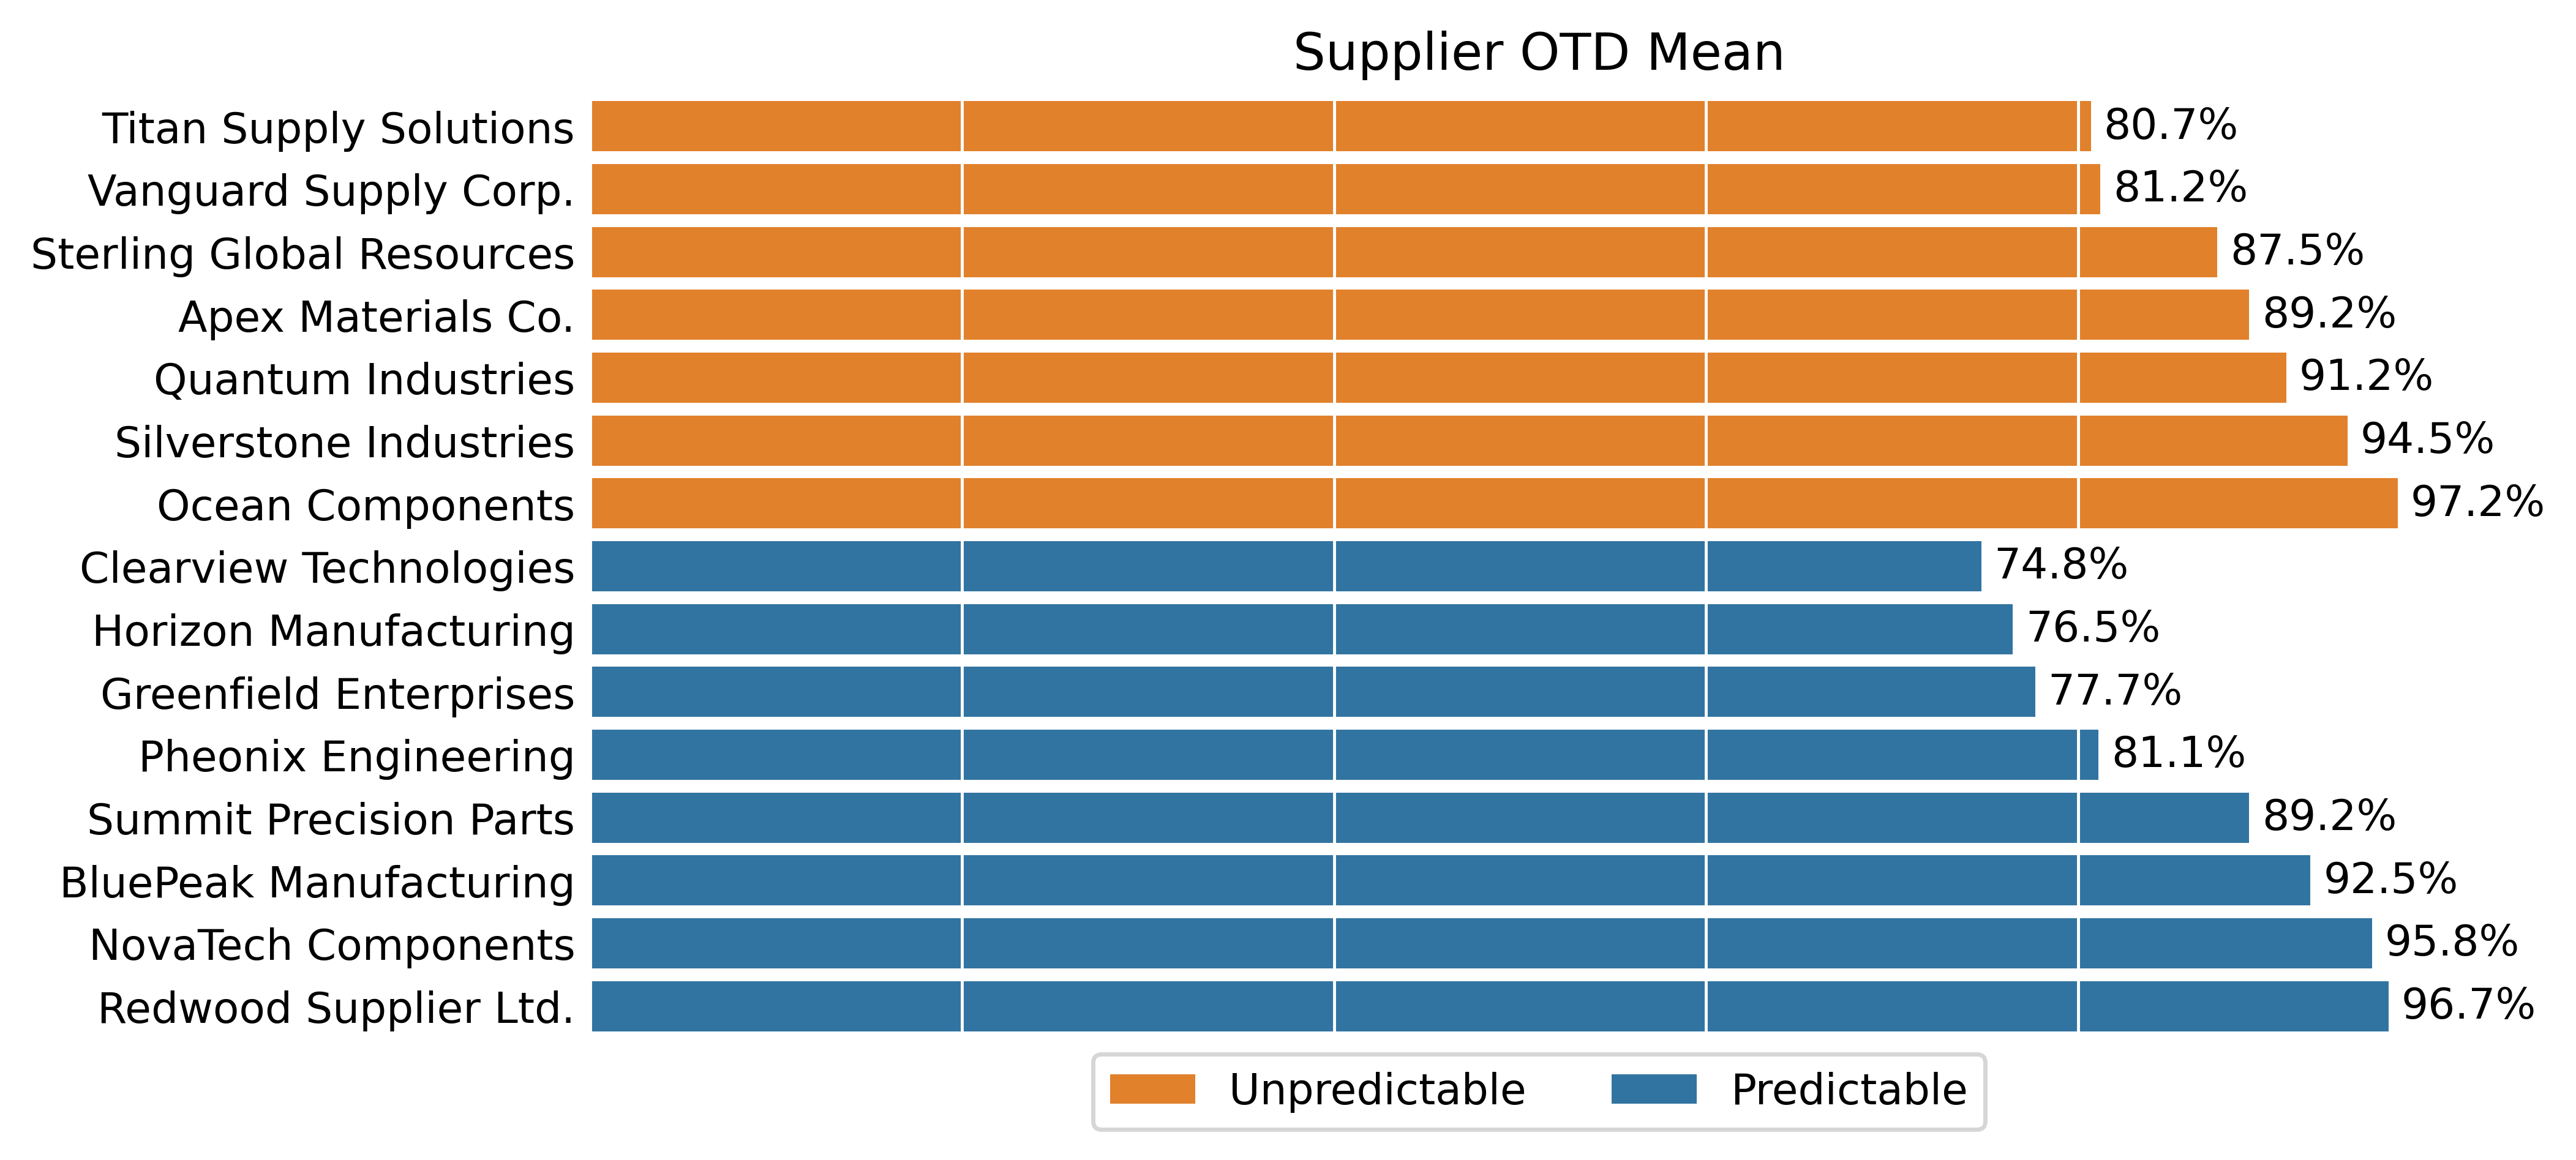

In [57]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8,4), dpi=500)

# Plot data
sns.barplot(na_means_sorted, y='Labels', x='Mean', 
            hue='Characterization', dodge=False, 
            palette=['tab:orange','tab:blue'])

# Add values to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

# Title
plt.title('Supplier OTD Mean', fontsize=12)
    
# Add white vertical grid lines
ax.grid(axis='x', color='white', linestyle='-', linewidth=0.7, zorder=3)
    
# Change x-tick color to white
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', length=0)
    
ax.set_ylabel('')
ax.set_xlabel('')
# ax.set_xlabel('Supplier OTD Mean', labelpad=-12)

# Move the legend above the graph and place items next to each other
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.12), 
          ncol=len(na_means_sorted['Characterization'].unique()))

# Remove all spines
sns.despine(bottom=True, left=True)

plt.show()

## Fig 3: XmR Chart of OTDs for Titan Supply solutions

In [66]:
# Select data from only Titan Supply Solutions
titan_df = df[df['Supplier'] == 'Titan Supply Solutions'].reset_index(drop=True).drop(columns=['Index'])
titan_df

,Supplier,Month,OTD
0,Titan Supply Solutions,Jan,81
1,Titan Supply Solutions,Feb,83
2,Titan Supply Solutions,Mar,59
3,Titan Supply Solutions,Apr,67
4,Titan Supply Solutions,May,76
5,Titan Supply Solutions,Jun,77
6,Titan Supply Solutions,Jul,77
7,Titan Supply Solutions,Aug,86
8,Titan Supply Solutions,Sep,91
9,Titan Supply Solutions,Oct,91


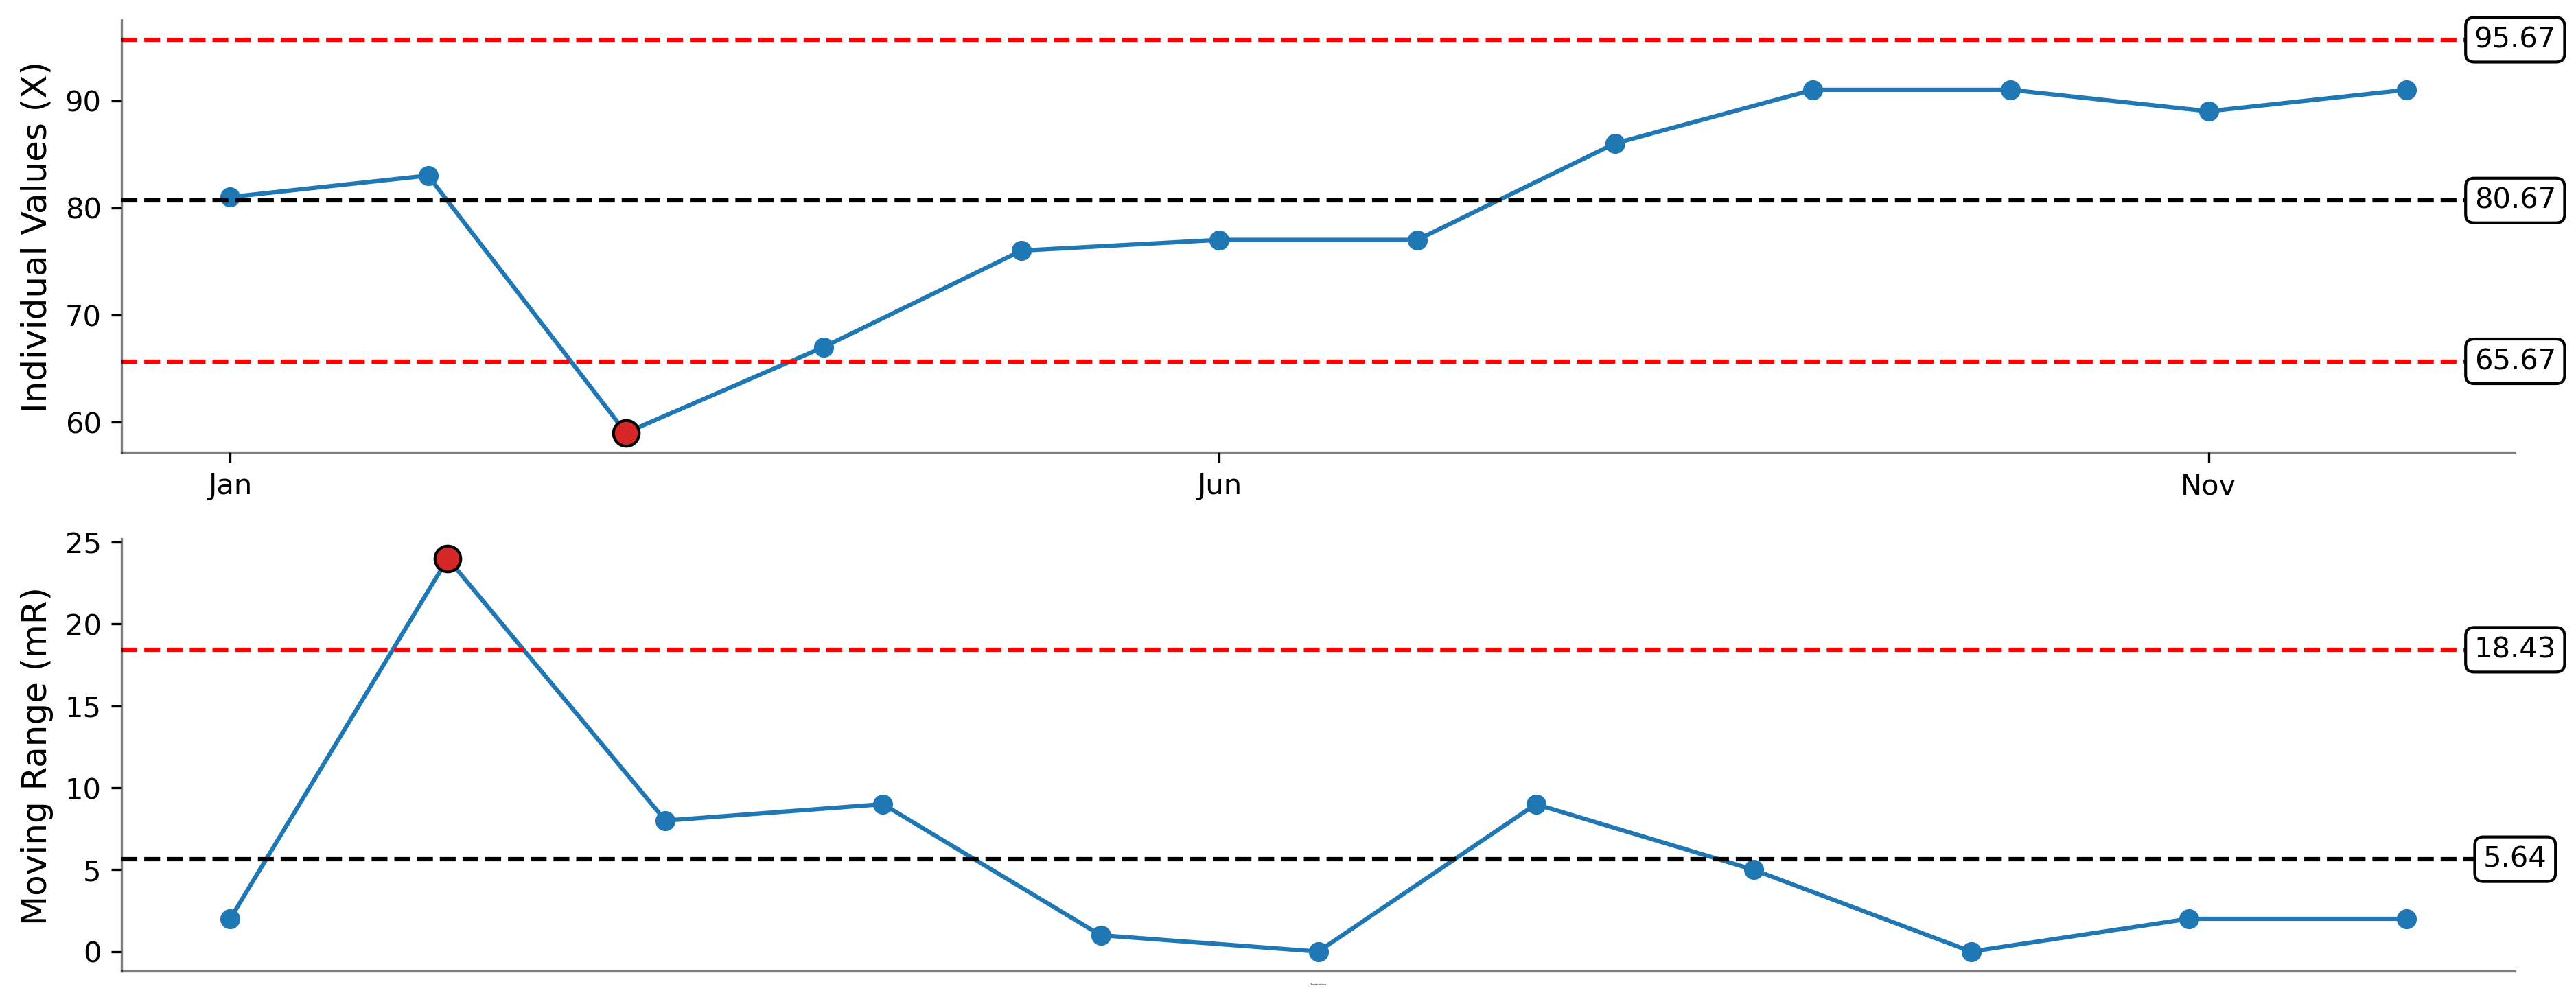

In [60]:
titan_xmr_results = xmr.xmrchart(titan_df, 'OTD', 'Month')

In [61]:
# Show titan XmR Chart results
titan_xmr_results['XmR Chart Statistics']

,Chart,PBC Params,Param Values
0,X-Chart,Mean,80.67
1,X-Chart,UPL,95.67
2,X-Chart,LPL,65.67
3,X-Chart,PLR,30.00
4,mR-Chart,Ave. mR,5.64
5,mR-Chart,URL,18.43


## Fig 4: Supplier OTD Process Limit Range (PLR)

In [51]:
# Sort network analysis results by characterization and process limit range
na_PLR_sorted = round(na_results.sort_values(by=['Characterization','PLR'], ascending=[False, False]),1).reset_index(drop=True)
na_PLR_sorted

,Labels,Mean,UPL,LPL,PLR,AmR,URL,Characterization
0,Sterling Global Resources,87.5,100.0,66.2,33.8,8.0,26.1,Unpredictable
1,Titan Supply Solutions,80.7,95.7,65.7,30.0,5.6,18.4,Unpredictable
2,Silverstone Industries,94.5,100.0,70.6,29.4,9.0,29.4,Unpredictable
3,Vanguard Supply Corp.,81.2,95.4,66.9,28.5,5.4,17.5,Unpredictable
4,Quantum Industries,91.2,100.0,82.3,17.7,3.4,11.0,Unpredictable
5,Apex Materials Co.,89.2,96.4,81.9,14.5,2.7,8.9,Unpredictable
6,Ocean Components,97.2,100.0,92.2,7.8,1.9,6.2,Unpredictable
7,Horizon Manufacturing,76.5,100.0,14.4,85.6,23.4,76.4,Predictable
8,Clearview Technologies,74.8,100.0,48.7,51.3,9.8,32.1,Predictable
9,Pheonix Engineering,81.1,100.0,56.2,43.8,9.4,30.6,Predictable


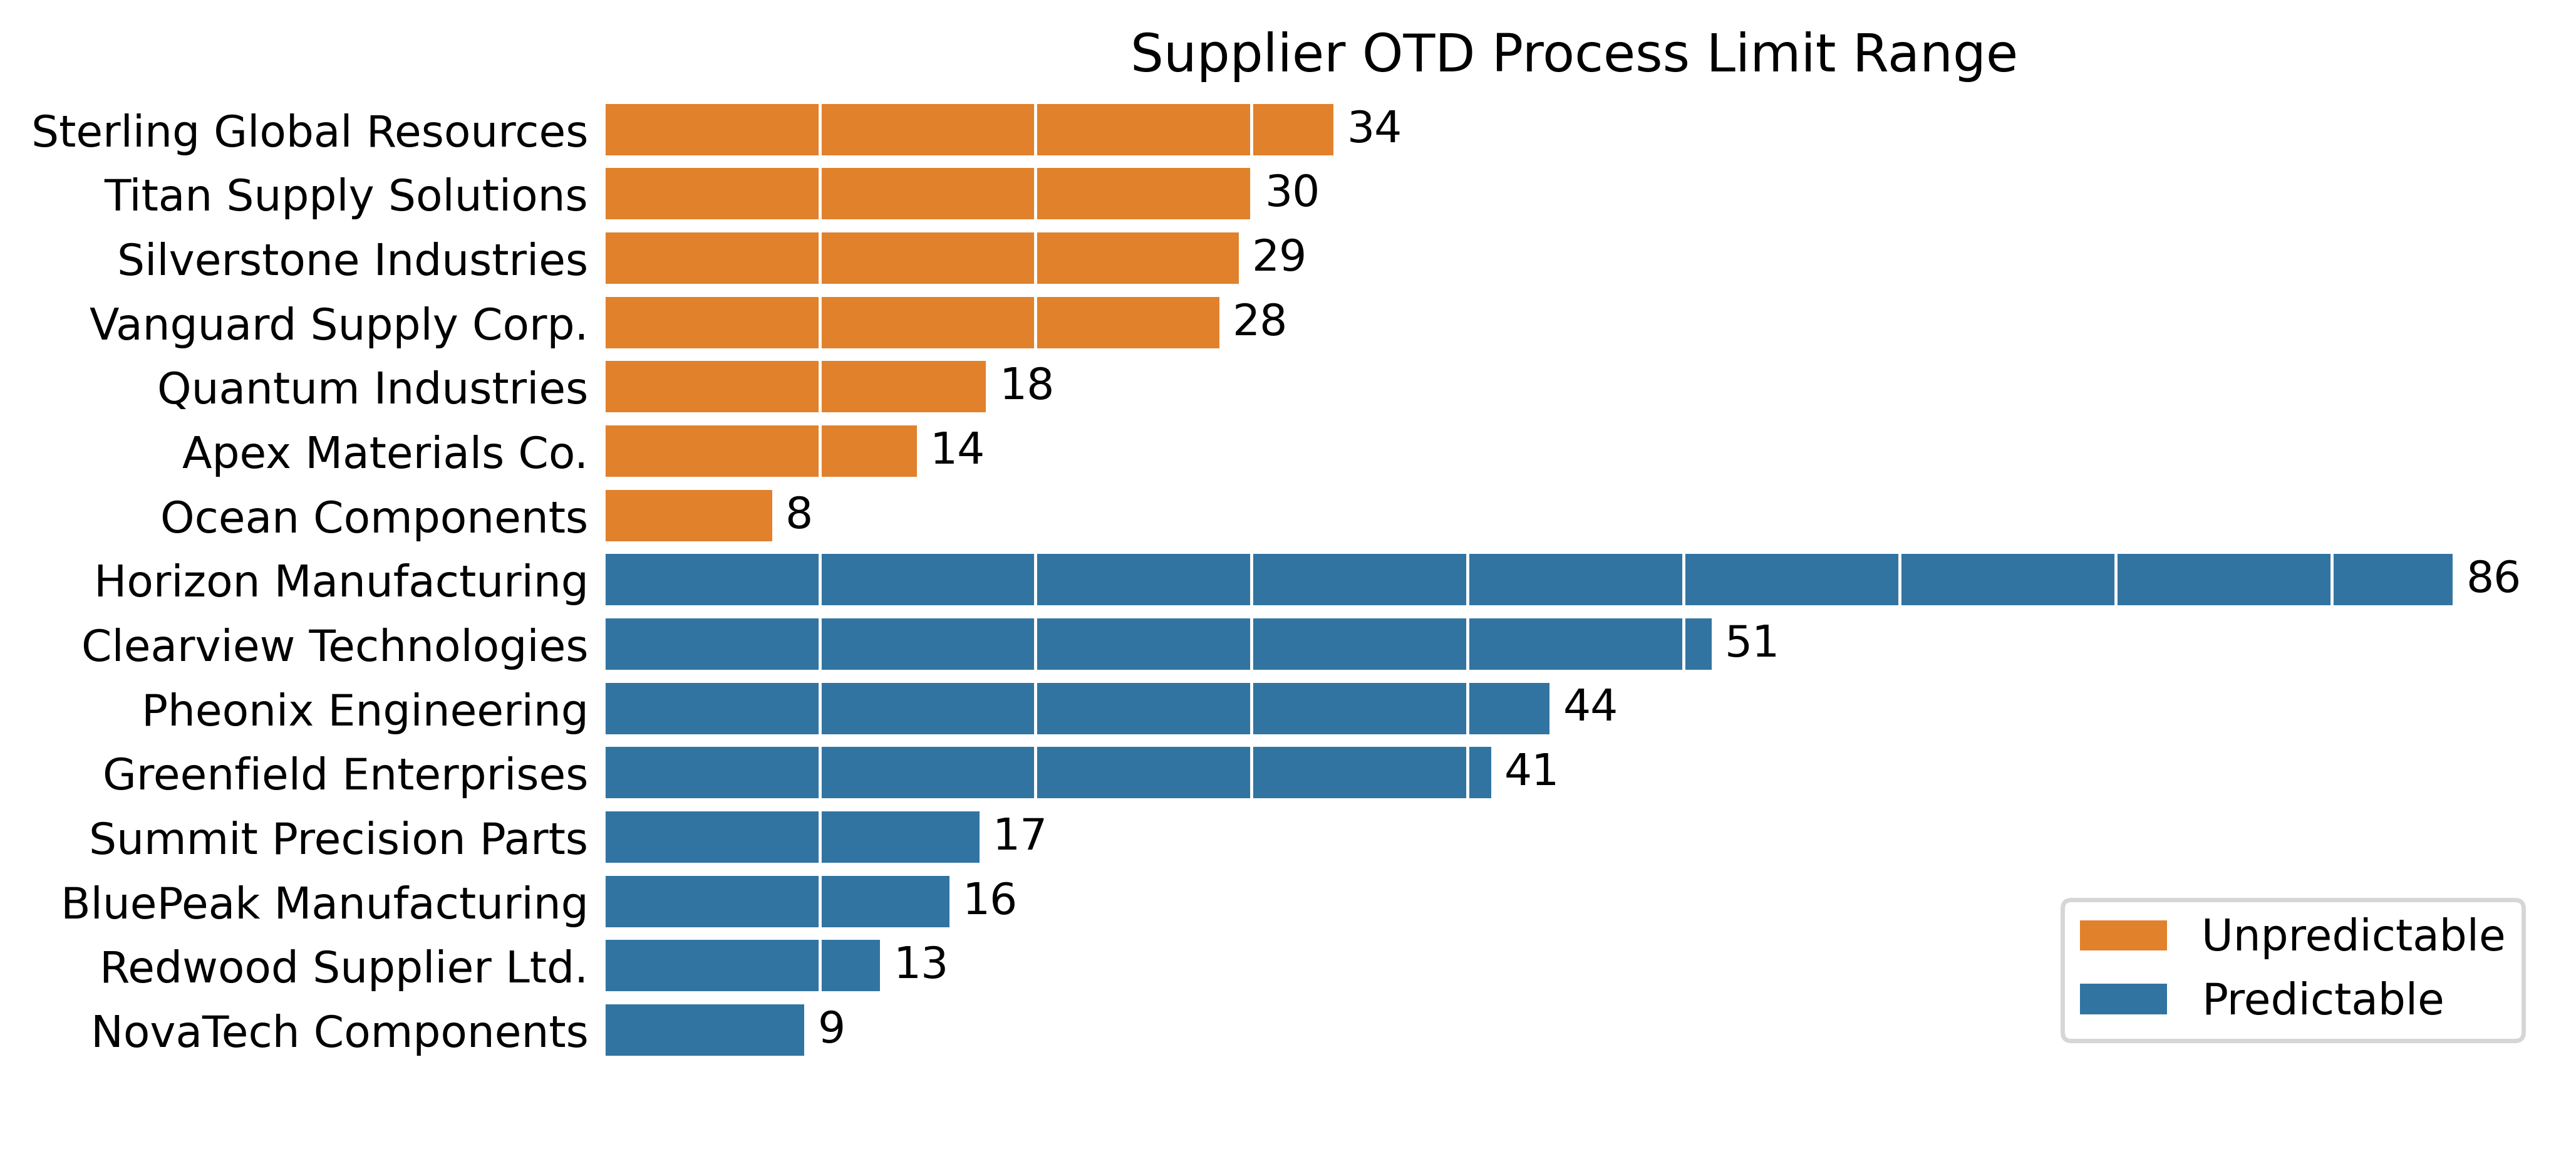

In [52]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8,4), dpi=500)

# Plot data
sns.barplot(na_PLR_sorted, y='Labels', x='PLR', 
            hue='Characterization', dodge=False, 
            palette=['tab:orange','tab:blue'])

# Add values to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
    
# Title
plt.title('Supplier OTD Process Limit Range', fontsize=12, ha='center')

# Add white vertical grid lines
ax.grid(axis='x', color='white', linestyle='-', linewidth=0.7, zorder=3)
    
# Change x-tick color to white
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', length=0)

# Remove x and y labels
ax.set_ylabel('')
ax.set_xlabel('')
# Specify legend location
ax.legend(loc='lower right')

# Remove all spines
sns.despine(bottom=True, left=True)

# Show plot
plt.show()

## Fig 5: XmR Chart of Horizon Manufacturing

In [65]:
# Create dataframe of just Horizon Manufacturing OTDs
horizon_df = df[df['Supplier'] == 'Horizon Manufacturing'].reset_index(drop=True).drop(columns=['Index'])
horizon_df

,Supplier,Month,OTD
0,Horizon Manufacturing,Jan,95
1,Horizon Manufacturing,Feb,75
2,Horizon Manufacturing,Mar,66
3,Horizon Manufacturing,Apr,76
4,Horizon Manufacturing,May,84
5,Horizon Manufacturing,Jun,99
6,Horizon Manufacturing,Jul,99
7,Horizon Manufacturing,Aug,98
8,Horizon Manufacturing,Sep,26
9,Horizon Manufacturing,Oct,87


In [73]:
# Special version of XmR chart limiting UPL to 100
# This version of xmrchart is avalible in process_improvement.py 1.1.0
def xmrchart(df, values, x_labels, xchart_title='', mrchart_title='', figsize=(15,6), 
             round_value=2, rotate_labels=0, tickinterval=1, dpi=300, 
             show_limit_values=True, restrict_UPL=False):
    """
    Generate an XmR chart (X-chart and mR-chart) from the provided DataFrame.

    The XmR chart consists of two parts:
    - X-chart: Displays individual values over time with control limits.
    - mR-chart: Displays moving ranges of consecutive observations.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing process measurement values and labels.
    values : str
        Column name containing the measured values.
    x_labels : str
        Column name containing the labels for the x-axis.
    xchart_title : str, optional
        Title for the X-chart. Default is an empty string.
    mrchart_title : str, optional
        Title for the mR-chart. Default is an empty string.
    figsize : tuple, optional
        Figure size in inches (width, height). Default is (15,6).
    round_value : int, optional
        Number of decimal places to round calculated statistics. Default is 2.
    rotate_labels : int, optional
        Angle to rotate x-axis labels. Default is 0 (horizontal).
    tickinterval : int, optional
        Interval for displaying x-axis ticks. Default is 2.
    dpi : int, optional
        Resolution of the figure in dots per inch. Default is 300.
    show_limit_values : bool, optional
        If True, displays numerical values for control limits. Default is True.

    Returns:
    --------
    dict
        A dictionary with two pandas DataFrames:
        - 'XmR Chart Statistics': Contains control limit values and centerline.
        - 'XmR Chart Dataframe': Original dataset with XmR variation classification.
    
    Raises:
    -------
    ValueError:
        - If `values` or `x_labels` columns are not in the DataFrame.
        - If `tickinterval` is not a positive integer.
        - If `figsize` is not a tuple of two positive numbers.
        - If the dataset has fewer than 2 observations (mR calculation fails).
    TypeError:
        - If `df` is not a pandas DataFrame.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame.")

    if values not in df.columns:
        raise ValueError(f"Column '{values}' not found in DataFrame.")
    
    if x_labels not in df.columns:
        raise ValueError(f"Column '{x_labels}' not found in DataFrame.")

    if not isinstance(tickinterval, int) or tickinterval <= 0:
        raise ValueError("tickinterval must be a positive integer.")

    if not (isinstance(figsize, tuple) and len(figsize) == 2 and all(isinstance(i, (int, float)) and i > 0 for i in figsize)):
        raise ValueError("figsize must be a tuple of two positive numbers (width, height).")    
    
    # Disaggregate the dataframe 
    data = df[values]
    moving_ranges = abs(data.diff())
    labels = df[x_labels]

    # Add moving ranges to df as column
    df = df.copy()
    df['Moving Ranges'] = pd.Series(moving_ranges)
    
    # Calculate the mean
    mean = round(data.mean(), round_value)
    # Calculate the average moving range 
    average_mR = round(moving_ranges.mean(), round_value)
    
    # Define the value of C1 and C2and calculate the UPL and LPL
    C1 = 2.660
    C2 = 3.268
    
    # Calculate the process limits
    if restrict_UPL:
        UPL = round(min(100,mean + (C1*average_mR)), round_value)
    else:
        UPL = round(mean + (C1*average_mR), round_value)
    # Calculate lower process limit    
    LPL = round(max(mean - (C1*average_mR),0), round_value)
    # Calculate process limit range (PLR)
    PLR = UPL - LPL
    # Conditionally determine LPL if LPL is less than zero
    LPL = max(LPL,0)
    # Calculate the Upper Range Limit
    URL = round(C2*average_mR, round_value)
    
    # Create masking parameters for values beyond process limits
    masked_values = {
        "upper_lim": np.ma.masked_where(data < UPL, data),
        "lower_lim": np.ma.masked_where(data > LPL, data),
        "url_greater": np.ma.masked_where(moving_ranges <= URL, moving_ranges)
    }

    # Define chart elements in structured lists
    xchart_lines = [(mean, 'black'), (UPL, 'red'), (LPL, 'red')]
    mrchart_lines = [(average_mR, 'black'), (URL, 'red')]

    # Create XmR Chart
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize, dpi=dpi)
    axs[0].plot(labels, data, marker='o')
    axs[1].plot(labels, moving_ranges, marker='o')

    # Function to highlight points outside process limits
    def highlight_outliers(ax, labels, masked_values, color='tab:red', size=9):
        for key, masked_data in masked_values.items():
            ax.plot(labels, masked_data, marker='o', ls='none', color=color,
                    markeredgecolor='black', markersize=size)

    # Apply outlier highlighting
    highlight_outliers(axs[0], labels, {"upper_lim": masked_values["upper_lim"], "lower_lim": masked_values["lower_lim"]})
    highlight_outliers(axs[1], labels, {"url_greater": masked_values["url_greater"]})

    # Add process limit lines
    for value, color in xchart_lines:
        axs[0].axhline(value, ls='--', c=color)
    for value, color in mrchart_lines:
        axs[1].axhline(value, ls='--', color=color)

    # Standardize axis formatting
    for ax in axs:
        ax.spines[['top', 'right']].set_visible(False)
        ax.spines[['left', 'bottom']].set_alpha(0.5)

    # Configure labels and tick marks
    axs[0].set_ylabel('Individual Values (X)', fontsize=12)
    axs[0].set_title(xchart_title, fontsize=14)

    tick_positions = np.arange(0, len(labels), tickinterval)
    axs[0].set_xticks(tick_positions)
    axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=rotate_labels, ha='center')

    axs[1].set_xlabel('Observation', fontsize=0)
    axs[1].set_ylabel('Moving Range (mR)', fontsize=12)
    axs[1].set_title(mrchart_title, fontsize=14)
    axs[1].set_xticks([])
    
    # Conditional show limit values
    if show_limit_values:
        limit_labels = [UPL, LPL, mean, URL, average_mR]
    else:
        limit_labels = ['UPL', 'LPL', 'Mean', 'URL', '$\overline{{mR}}$']

    # Get x limit of subplots
    xlimit = axs[0].get_xlim()[1]
    mR_xlimit = axs[1].get_xlim()[1]

    # Define the annotation data
    annotations = [
        (limit_labels[0], xlimit, UPL, axs[0]),  # UPL annotation on ax[0]
        (limit_labels[1], xlimit, LPL, axs[0]),  # LPL annotation on ax[0]
        (limit_labels[2], xlimit, mean, axs[0]),  # Mean annotation on ax[0]
        (limit_labels[3], mR_xlimit, URL, axs[1]),  # USL annotation on ax[1]
        (limit_labels[4], mR_xlimit, average_mR, axs[1]),  # LSL annotation on ax[1]
    ]
    
    # Add annotations
    for label, x_pos, y_pos, axis in annotations:
        axis.annotate(label,
                      xy=(x_pos, y_pos),
                      ha='center',
                      va='center',
                      bbox=dict(facecolor='white', boxstyle='round'))
    
    # Despine plot
    sns.despine()
    
    # Show XmR Chart figure
    plt.show()
    
    # Create functions for labeling types of variation 
    def xchart_variation(value):
        if (value > UPL) | (value < LPL):
            return 'Assignable Cause'
        else:
            return 'Common Cause'
    
    def mrchart_variation(value):
        if value > URL:
            return 'Assignable Cause'
        else:
            return 'Common Cause'
    
    # Apply variation_conditions
    df['X-Chart Variation'] = df[values].apply(xchart_variation)
    df['mR-Chart Variation'] = df['Moving Ranges'].apply(mrchart_variation)
    
    # Create list of PBC paramters
    chart_type = ['X-Chart']*4
    chart_type.extend(['mR-Chart'] * 2)
    param_names = ['Mean','UPL','LPL','PLR','Ave. mR','URL']
    param_values = [round(x,round_value) for x in [mean,UPL,LPL,PLR,average_mR,URL]] 
   
    # Create df for PBC parameters
    PBC_params_df = pd.DataFrame()
    PBC_params_df['Chart'] = pd.Series(chart_type)
    PBC_params_df['PBC Params'] = pd.Series(param_names)
    PBC_params_df['Param Values'] = pd.Series(param_values)
    
    # Create dictionary of dfs
    result_dfs = {'XmR Chart Statistics':PBC_params_df, 
                  'XmR Chart Dataframe':df
                 }
    
    return result_dfs

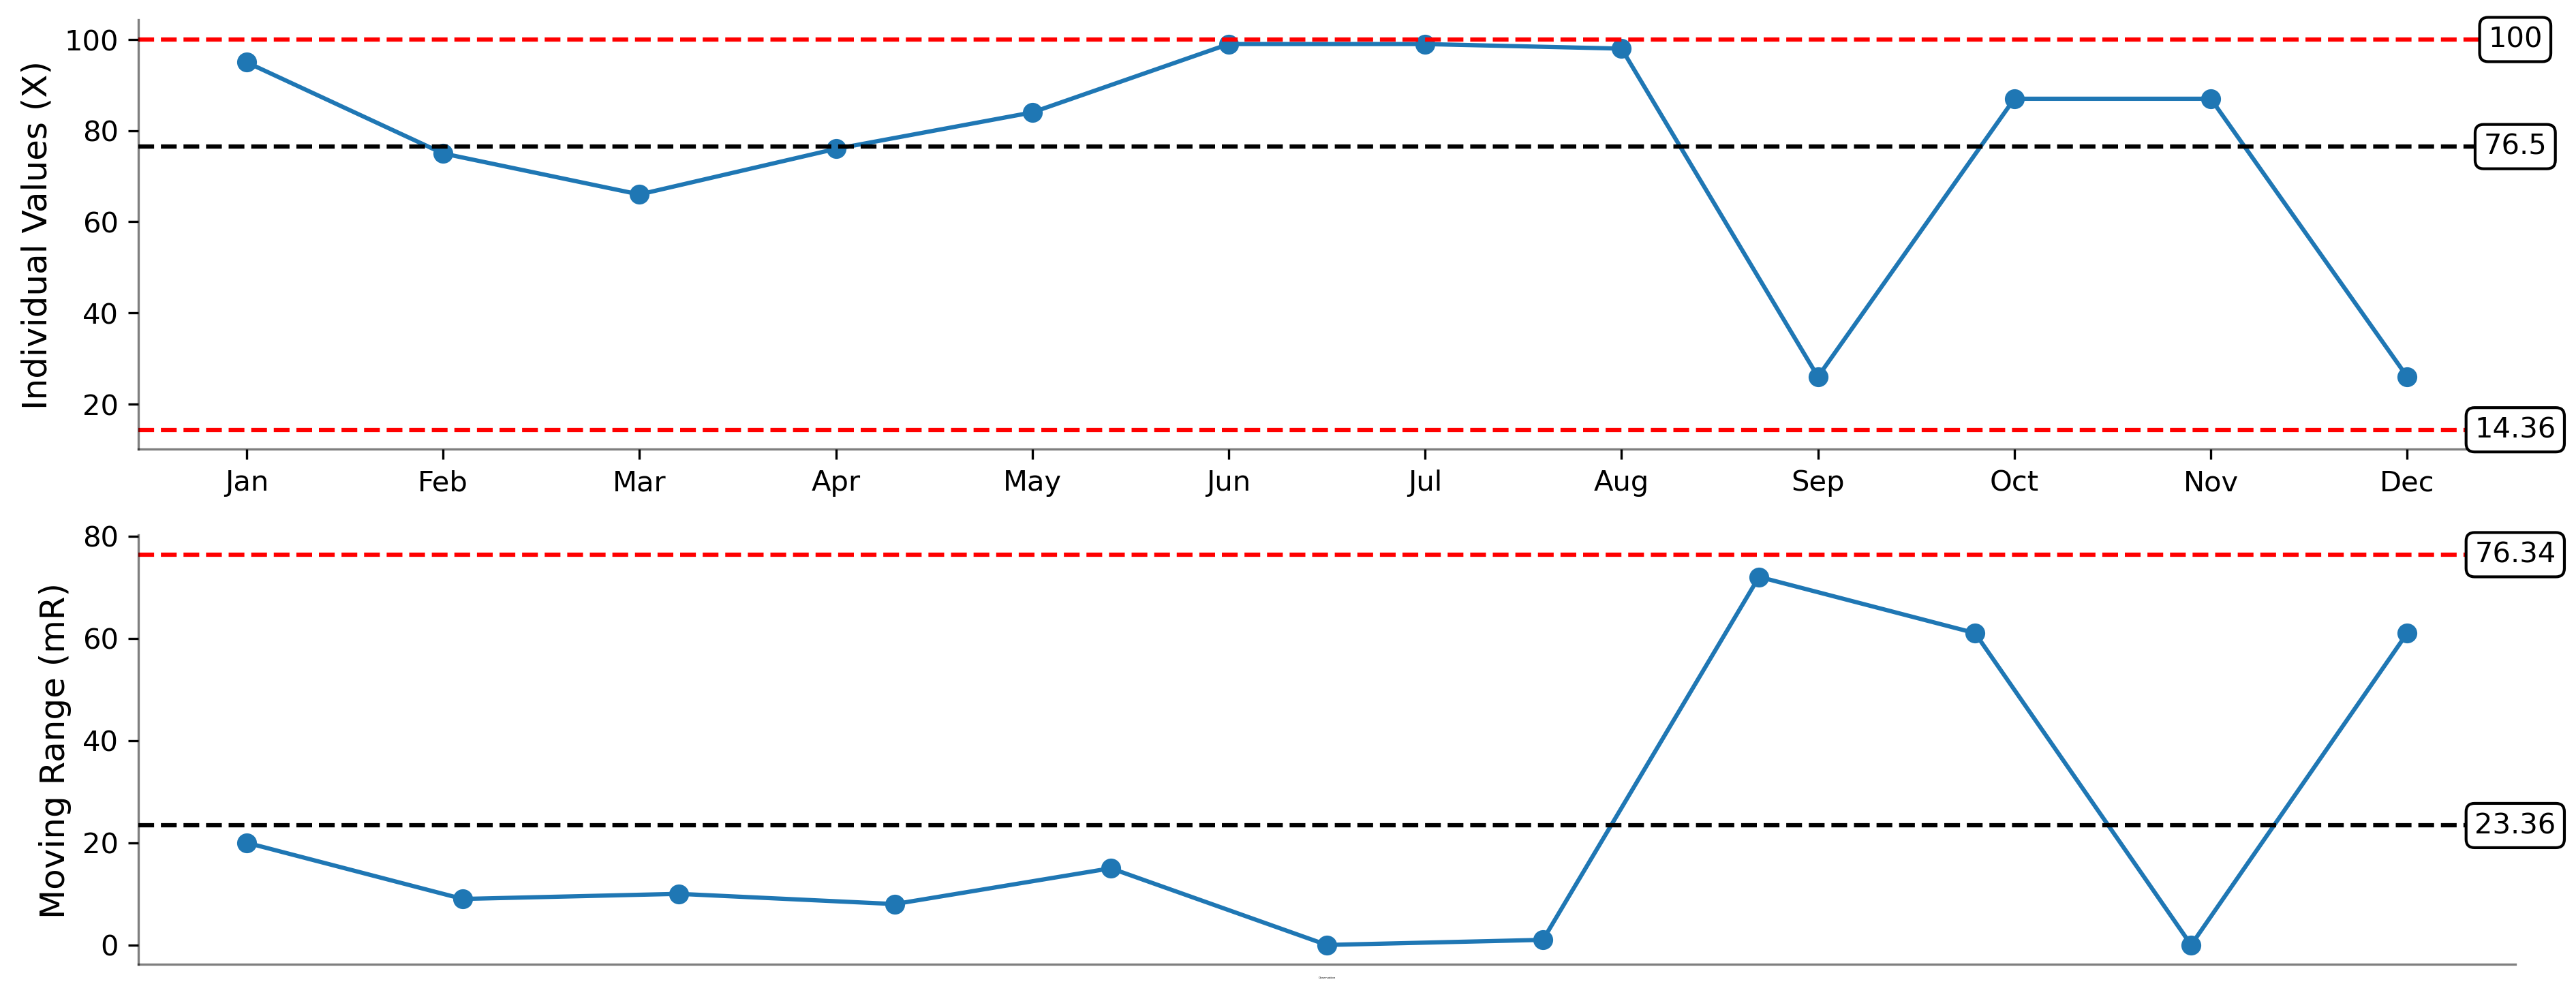

In [75]:
horizon_xmr_results = xmrchart(horizon_df, 'OTD', 'Month', restrict_UPL=True)